### Plot temperature and humidity data

In [2]:
from datetime import datetime
from datetime import timedelta
import numpy as np
data_N = 1 # smoothing factor for data reading
def read_data(file_path):
    trace = []
    with open(file_path, 'r') as f:
        # extract start time from start time
        first_line = f.readline()
        data = first_line.strip().split(',')
        start_time = datetime.strptime(data[0], '%H:%M:%S.%f')
        last_time = start_time
        negFlag = False # use a flag to avoid loops
        breakFlag = False

        while True:
            buf = []
            for i in range(0, data_N):
                line = f.readline()
                data = line.strip().split(',')
                cur_time = datetime.strptime(data[0], '%H:%M:%S.%f')
                # elapsed time in hours
                elapsed_time_h = (cur_time - start_time).total_seconds() / 3600
                
                if elapsed_time_h < 0:
                    # add another day to avoid negative elapsed time
                    negFlag = True
                    elapsed_time_h += 24
                elif negFlag == True and elapsed_time_h > 0:
                    # finish processing all the data, end the loop
                    breakFlag = True
                    break

                # process voltage, current and power data
                temp = int(data[5])
                humid = int(data[6])
                buf.append([elapsed_time_h, temp, humid])
                
            # use the average
            if len(buf) != 0: # buf is not empty
                buf = np.array(buf)
                trace.append(np.mean(buf, axis=0))
            
            if breakFlag:
                break
    return np.array(trace)

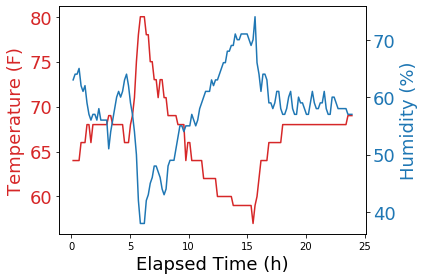

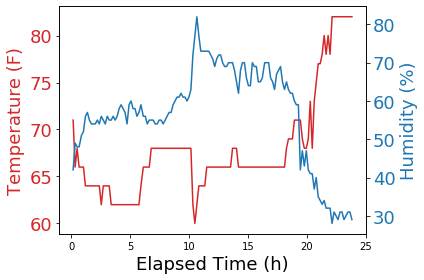

In [3]:
import matplotlib.pyplot as plt
def plot(trace, fname):
    fig, ax1 = plt.subplots()
    color = "tab:red"
    ax1.plot(trace[:, 0], trace[:, 1], color=color)
    ax1.set_xlabel("Elapsed Time (h)", fontsize=18)
    ax1.set_ylabel("Temperature (F)", color=color, fontsize=18)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=18)

    ax2 = ax1.twinx()
    color = "tab:blue"
    ax2.plot(trace[:, 0], trace[:, 2], color=color)
    ax2.set_ylabel('Humidity (%)', color=color, fontsize=18)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=18)

    fig.tight_layout()
    plt.savefig(fname, dpi=300)

data_solar = read_data('./data/recv_data_solar.txt')
data_bat = read_data('./data/recv_data_bat.txt')

plot(data_solar, './img/solar.png')
plot(data_bat, './img/bat.png')

### calculate the gradient factor x in a EWMA manner

[40.0, 40.0, 40.0, 40.0, 29.47497027946568, 33.68498216767941, 36.21098930060764, 27.215291828216337, 32.3291750969298, 24.875298597695537, 20.413337974604715, 28.248002784762832, 32.9488016708577, 35.76928100251462, 37.46156860150877, 38.47694116090526, 39.08616469654316, 39.451698817925895, 34.41770016894957, 36.650620101369746, 32.733516332240605, 35.640109799344366, 37.38406587960662, 38.43043952776397, 39.05826371665838, 39.43495822999503, 29.13535507118236, 33.48121304270941, 36.08872782562565, 27.12977930966744, 27.016703953282175, 21.684379034132093, 7.965016920766487, 5.0, 8.487279679681112, 21.092367807808667, 28.655420684685204, 22.666696036722165, 29.6000176220333, 17.9720443848814, 26.783226630928837, 21.55928017922503, 28.93556810753502, 22.834903706686426, 19.179493307149702, 27.50769598428982, 21.979981588366066, 29.18798895301964, 22.987753958202113, 29.792652374921268, 33.87559142495276, 36.32535485497166, 37.795212912983, 33.41647606708704, 36.04988564025223, 37.6299

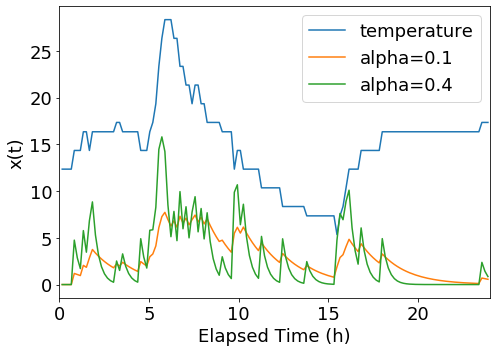

In [31]:
def gen_x(alpha):
    last_x = 0
    x = [last_x]
    for i in range(1, data_solar.shape[0]):
        # calculate the gradient in the past interval
        grad = abs(data_solar[i, 1] - data_solar[i-1, 1]) / (data_solar[i, 0] - data_solar[i-1, 0])
        new_x = alpha * grad + (1 - alpha) * last_x
        x.append(new_x)
        last_x = new_x
    return x

plt.figure(figsize=(7, 5))
plt.plot(data_solar[:, 0], data_solar[:, 1] - np.mean(data_solar[:, 1]) + 15, label='temperature')
plt.plot(data_solar[:, 0], gen_x(0.1), label='alpha=0.1')
plt.plot(data_solar[:, 0], gen_x(0.4), label='alpha=0.4')
plt.xlim((0, 24))
plt.xlabel("Elapsed Time (h)", fontsize=18)
plt.ylabel("x(t)", fontsize=18)
plt.tick_params(labelsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

I = []
x = gen_x(0.4)
I_max = 40
I_min = 5
k = (I_max - I_min) / max(x)
for ele in x:
    next_I = I_max - k * ele
    I.append(next_I)
print(I)
print(k)